In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
import warnings
warnings.filterwarnings("ignore")
cols_to_show = 150

In [6]:
def h(content):
    display(HTML(content))
    
def timehist1(col):
    #Not sure what this is doing???
    N = 8000 if col in ['TransactionAmt'] else 99999999999999
    
    tr[tr['isFraud']==0].set_index('TransactionDT')[col].clip(0, N).plot(style='.', title='Hist ' + col, figsize=(15,3))
    tr[tr['isFraud']==1].set_index('TranasactionDT')[col].clip(0,N).plot(style='.', title='Hist ' + col, figsize=(15,3))
    te.set_index('TransactionDT')[col].clip(0,N).plot(style='.', title='Blue = no fraud, orange = fraud, green = test', figsize=(15,3))
    plt.show()

def _desc(data, col, label):
#Function used in conjunction with desc1, calculates descriptive statistics but also adds the numer of unique values,
#NaN count and what proportion NaNs make
    d0 = data.describe().reset_index()
    d0.columns = [col, label]
    return d0.append({col:'unique values', label:data.unique().shape[0]}, ignore_index=True) \
            .append({col:'NaNs', label:data.isnull().sum()}, ignore_index=True) \
            .append({col:'NaN share', label:np.round(data.isnull().sum()/data.shape[0], 4)}, ignore_index=True)


def desc1(col):
#Used to compare descriptive statistics of  particular feature across the train and test set
#Train set broken up into fraud vs non-fraud values, test set broken up into public vs private leaderboard
#Each individual column is generated using _desc
    d0 = _desc(tr[col], col, 'Train')
    d1 = _desc(tr.loc[tr['isFraud']==1, col], col, 'Train fraud')
    d2 = _desc(tr.loc[tr['isFraud']==0, col], col, 'Train not fraud')
    d3 = _desc(te[col], col, 'Test')
    n_public = int(te.shape[0]*0.2)
    d4 = _desc(te.loc[:n_public, col], col, 'Test public')
    d5 = _desc(te.loc[n_public:, col], col, 'Test private')
    dd = d0.merge(d1).merge(d2).merge(d3).merge(d4).merge(d5)
    display(dd)
    
    #Creates additional table that looks more in depth at relationship between feature and target across train and test
    if col not in ['TransactionID']:
        h('<b>Most popular values (NaN = -999): </b>')
        N = 10
        d0 = tr[['isFraud',col]].fillna(-999).groupby(col)['isFraud'].agg(['size','mean','sum']).reset_index().sort_values('size',ascending=False).reset_index(drop=True)
        d1 = te[['TransactionID', col]].fillna(-999).groupby(col)['TransactionID'].count().reset_index()
        dd = d0.merge(d1, how='left', on=col).head(N)
        dd = dd.rename({'size':'Count in train (desc)', 'mean':'Mean target', 'sum': 'Sum target','TransactionID':'Count in test'}, axis=1)
        display(dd)
        
        h('<b>Biggest fraud sum values in train (NaN=-999):</b>')
        dd2 = dd.sort_values('Sum target',ascending=False)
        dd2.columns = [col, 'Count in train','Mean target','Sum target (desc)','Count in test']
        display(dd2)
        
def hist1(col):
#Creates histogram comparing feature across train and test set
    plt.figure(figsize=(15,3))
    plt.subplot(121)
    plt.hist(tr[col], bins=70)
    plt.title('Train histogram: '+ col);
    plt.subplot(122)
    plt.hist(te[col], bins=70);
    plt.title('Test histogram: '+ col);
    plt.show()


included_cols = list(tr.columns.values[:cols_to_show])

def corr1(col):
        N = None
        num_vars = [f for f in tr.columns if tr[f].dtype != 'object']
        trx = tr.head(N) if N is not None else tr.copy()
        corrs = trx[num_vars].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column', 0:'Correlation with ' + col}, axis=1)
        h('<b>Most correlated values with '+ col + ':</b>')
        trx = pd.concat([corrs.head(6), corrs.dropna().tail(5)])
        
        #Converts values into html link, but why though?
        def linkx(val):
            return '<a href="#c_{}">{}</a>'.format(val, val) if val in included_cols else val
        
        trx['Column'] = trx['Column'].apply(linkx)
        h(trx.to_html(escape=False))

def numeric(col):
    timehist1(col)
    hist1(col)
    desc1(col)
    corr1(col)

def categorical(col):
    desc1(col)

def proc(col):
    if col not in ['isFraud', 'TransactionDT']:
        h('<h3 id="c_' + col + '">' + col + '</h3>' + '<a style="font-size:11px" href="#home">(Jump to top) </a>')
        categorical(col) if tr[col].dtype == 'object' else numeric(col)

    

In [3]:
tr = pd.read_csv('Data/train_transaction.csv')
te = pd.read_csv('Data/test_transaction.csv')
trid = pd.read_csv('Data/train_identity.csv')
teid = pd.read_csv('Data/test_identity.csv')

I'm now reasonably satisfied that I understand Alji's notebook so I will move onto playing around with Chris' work. Chris focuses on trying to cut down the number of V variables used. V variables are engineered from the existing data so may not contain new information.

In [4]:
#Separation of columns into raw and engineered features (t and v)
cols_t = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

cols_v = ['V'+str(x) for x in range(1,340)]

#Creation of dictionary storing datatypes of V cols
types_v = {}
for c in cols_v: types_v[c] = 'float32'

In [5]:
#Looking at NaN structure
nans_df = tr.isna()
nans_groups = {}
i_cols = ['V'+str(i) for i in range(1,340)]
for col in tr.columns:
    #getting NaNs count for a particular feature
    cur_group = nans_df[col].sum()
    
    #if NaN count matches what is already in the dictionary, then add the name of the feature to the group, else
    try:
        nans_groups[cur_group].append(col)
    
    #create a new group with key equal to the nan count, and value equal to the name of the feature
    except:
        nans_groups[cur_group]=[col]

In [37]:
for k, v in nans_groups.items():
    print('NaN count = ', k)
    print(v)
    print(len(v))

NaN count =  0
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
20
NaN count =  8933
['card2']
1
NaN count =  1565
['card3']
1
NaN count =  1577
['card4']
1
NaN count =  4259
['card5']
1
NaN count =  1571
['card6']
1
NaN count =  65706
['addr1', 'addr2']
2
NaN count =  352271
['dist1']
1
NaN count =  552913
['dist2']
1
NaN count =  94456
['P_emaildomain']
1
NaN count =  453249
['R_emaildomain']
1
NaN count =  1269
['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315']
12
NaN count =  280797
['D2']
1
NaN count =  262878
['D3']
1
NaN count =  168922
['D4']
1
NaN count =  309841
['D5']
1
NaN count =  517353
['D6']
1
NaN count =  551623
['D7']
1
NaN count =  515614
['D8', 'D9']
2
NaN count =  76022
['D10']
1
NaN count =  279287
['D11', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']
12
NaN count =  525823
[

Some groups may use similar aggregation/engineering patterns. For example consider the groups with the same NaN count as D11 and D1, they have the same number of features indicating that a similar process was used to derive V1-V11 and V281, V282, V283, V288,..,V315.

In [38]:
print(nans_groups[1269], nans_groups[279287])

['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315'] ['D11', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']


It might be worth trying to reverse engineer their techniques sometime in the future...

In [6]:
#Examining V1-11 and D1
Vc = ['dayr', 'isFraud', 'TransactionAmt', 'card1', 'addr1', 'D1n', 'D11n']
Vs = nans_groups[279287]
Vtitle = 'V1 - V11, D11'

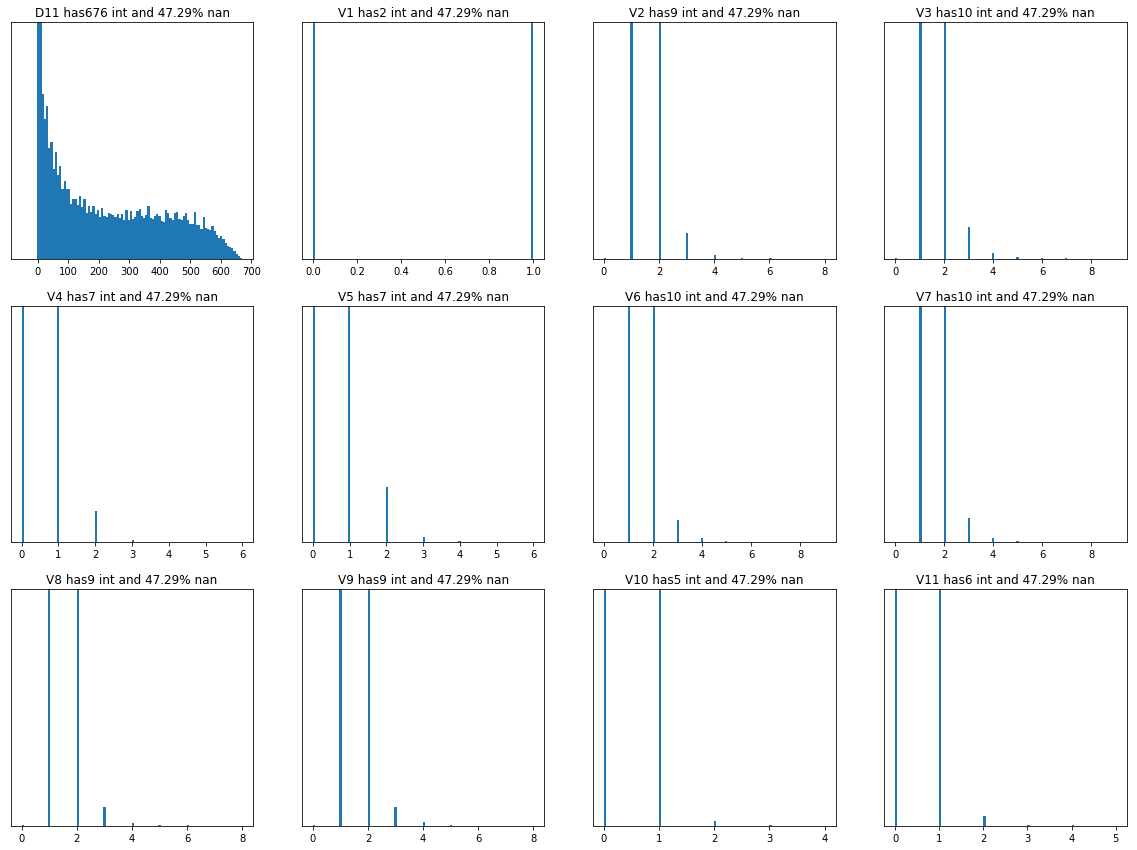

In [35]:
def make_plots(Vs):
    
    #Formatting dimensions of plot
    col = 4
    row = len(Vs)//col+1
    plt.figure(figsize=(20,row*5))
    
    #Getting indices for non NaN values
    idx = tr[~tr[Vs[0]].isna()].index
    
    
    for i, v in enumerate(Vs): #Enumerate i is the counter, v is the actual object
        
        #Filling subplot
        plt.subplot(row, col, i+1)
        
        #Counts unique values
        n = tr[v].nunique()
        
        #????
        x = np.sum(tr.loc[idx, v]!=tr.loc[idx,v].astype(int))
        
        #NaN percentage
        y = np.round(100*np.sum(tr[v].isna())/len(tr),2)
        t = 'int'
        
        #For case that x is not int???
        if x!=0:
            t = 'float'
            
        plt.title(v + ' has' + str(n) + ' ' + t + ' and ' + str(y) + '% nan')
        plt.yticks([])
        
        h = plt.hist(tr.loc[idx,v], bins=100)
        
        #Truncating the y-axis
        if len(h[0])>1:
            plt.ylim((0, np.sort(h[0])[-2]))
            
make_plots(Vs)
    

In [59]:
def make_corr(Vs, Vtitle = ''):
    cols = ['TransactionDT'] + Vs
    plt.figure(figsize=(15,15))
    sns.heatmap(tr[cols].corr(), cmap = 'RdBu_r', annot=True, center= 0.0)

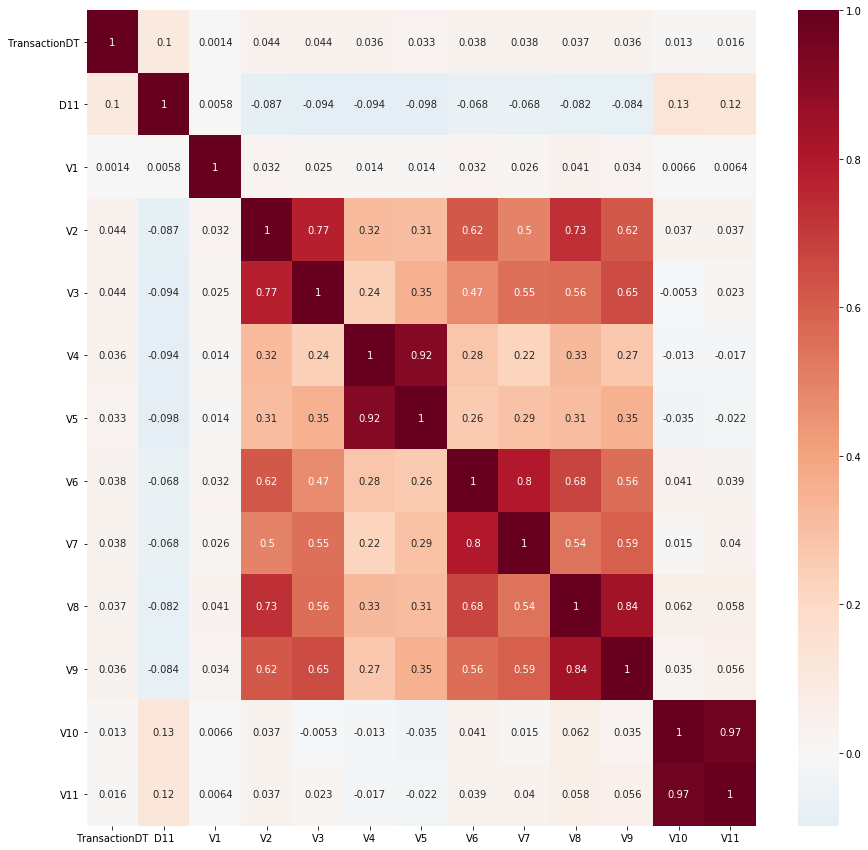

In [60]:
make_corr(Vs)

After identifying correlations, we can manually assign variables into sub groups where correlation is greater than 0.75. Then you choose the variables with the most unique values because it contains the most information.

In [64]:
grps = [[1], [2,3], [4,5], [6,7], [8,9], [10,11]]

def reduce_groups(grps, c='V'):
    use = []
    for g in grps:
        mx = 0
        vx=g[0]
        for gg in g:
            n = tr[c+str(gg)].nunique()
            if n > mx :
                mx = n
                vx = gg
        use.append(vx)
    print('Use these', use)

Let's see if we can code up an algorithm to identify correlated variables, and automatically group. Chris' groupings were read manually off the heatmap.

In [73]:
corrs = tr[Vs].corr()
grps = []
grouped = []
group = 0 
for i,v in enumerate(Vs):
    for j in range(0+i,len(Vs)):
        corr = corrs.iloc[i,j]
        
        if grps == {}:
            grps[group] = Vs[j]
            
        if corr > 0.75:
            grps[i].append(Vs)
        

1.0
0.005824589864063877
-0.08716226955187587
-0.09357861947199746
-0.09382189703299078
-0.09836591367598875
-0.06805460879389666
-0.06752234792282392
-0.08167415032657391
-0.08432787947030719
0.12796451136744313
0.12211438208810252
1.0
0.03216842692248582
0.024829797268841443
0.014216065475371248
0.013619377964165633
0.03228381590533755
0.026016122858589907
0.0408200452672036
0.03400890944450191
0.006574249035339283
0.006408047124962316
1.0
0.7730390376762973
0.31855389087895264
0.3055044267126589
0.6214593046696353
0.49692071429298124
0.7327302970860277
0.6185910368026867
0.03688380449730736
0.0374587247772028
1.0
0.2436840295420808
0.3537668994174819
0.47257042433744073
0.5468748939951985
0.5565363507966249
0.653087474126225
-0.0052718760478738455
0.022911415671578797
1.0
0.9151637593183779
0.2795964712945345
0.2216212199000673
0.3258725782253801
0.27320721872024134
-0.013159846372305722
-0.01666230312346102
1.0
0.26149022582956477
0.2944470600884181
0.30871565529847134
0.3542569635

In [75]:
corrs

,D11,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
D11,1.000000,0.005825,-0.087162,-0.093579,-0.093822,-0.098366,-0.068055,-0.067522,-0.081674,-0.084328,0.127965,0.122114
V1,0.005825,1.000000,0.032168,0.024830,0.014216,0.013619,0.032284,0.026016,0.040820,0.034009,0.006574,0.006408
V2,-0.087162,0.032168,1.000000,0.773039,0.318554,0.305504,0.621459,0.496921,0.732730,0.618591,0.036884,0.037459
V3,-0.093579,0.024830,0.773039,1.000000,0.243684,0.353767,0.472570,0.546875,0.556536,0.653087,-0.005272,0.022911
V4,-0.093822,0.014216,0.318554,0.243684,1.000000,0.915164,0.279596,0.221621,0.325873,0.273207,-0.013160,-0.016662
V5,-0.098366,0.013619,0.305504,0.353767,0.915164,1.000000,0.261490,0.294447,0.308716,0.354257,-0.035405,-0.021949
V6,-0.068055,0.032284,0.621459,0.472570,0.279596,0.261490,1.000000,0.796027,0.675501,0.561332,0.040767,0.038673
V7,-0.067522,0.026016,0.496921,0.546875,0.221621,0.294447,0.796027,1.000000,0.538586,0.594988,0.014593,0.039807
V8,-0.081674,0.040820,0.732730,0.556536,0.325873,0.308716,0.675501,0.538586,1.000000,0.835342,0.061869,0.058033
V9,-0.084328,0.034009,0.618591,0.653087,0.273207,0.354257,0.561332,0.594988,0.835342,1.000000,0.034524,0.055620


In [72]:
range(0,len(Vs))

range(0, 12)

In [77]:
test = {1:'a'}

'a'